# Test of every function

In [1]:
from implementations import *
from helpers import *
import matplotlib.pyplot as plt
import numpy as np
from functions import *

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data('dataset_to_release/', sub_sample=False)

Size of x_train :  (328135, 321)
Size of y_train :  (328135,)
Size of x_test :  (109379, 321)


Presence of duplicata :  False


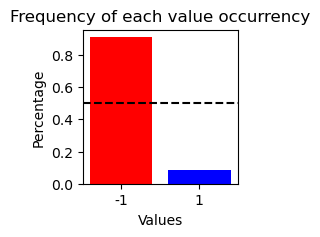

Shape x_train after standardization :  (328135, 306)
Shape y_train after standardization:  (328135,)


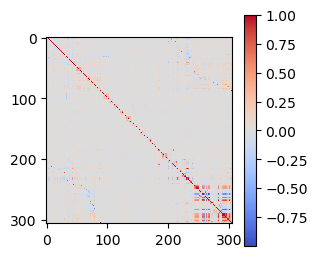

Shape x_train after corr :  (328135, 264)
Shape y_train after corr:  (328135,)
Finale shape of x_train :  (328135, 265)
Finale shape of y_train :  (328135,)
Finale shape of x_test :  (109379, 265)


In [3]:
#check if duplicates in x_train
duplicata(x_train)    

#shuffle x_train and y_train at the same time to shuffle them in the same way
x_train1, y_train1 = shuffle_rows (x_train, y_train)

#check the distribution of sick and not sick
test_balancy_dataset(y_train1)
    
#premiere colonne remplie de Nan (supprimer d autres des premieres colonnes)
x_train1 = x_train1[:,9:]
x_test1 = x_test[:,9:]

#remplacer Nan par mediane (estce qu on a le droit de faire ca dans xtest? estce que cest une bonne idee ?)
x_train1=nan_to_median(x_train1)
x_test1=nan_to_median(x_test1)

#standardization of test
x_test1, _ = standardize_(x_test1)

#enlever les colonnes qui ont une std nulle
x_train1, col_to_keep=remove_zero_std_columns(x_train1)
x_test1= x_test1[:, col_to_keep]
print('Shape x_train after standardization : ', x_train1.shape)
print('Shape y_train after standardization: ', y_train1.shape)

#enlever les colonnes avec trop grande correlation
x_train1, col_to_delete=remove_high_correlation_feature(x_train1)
x_test1= np.delete(x_test1, col_to_delete, axis = 1)
print('Shape x_train after corr : ', x_train1.shape)
print('Shape y_train after corr: ', y_train1.shape)


#Add a column of ones TO USE ONLY WITH SUBSETS
x_train1 = build_model_data(x_train1)
x_test1 = build_model_data(x_test1)

print('Finale shape of x_train : ', x_train1.shape)
print('Finale shape of y_train : ', y_train1.shape)
print('Finale shape of x_test : ', x_test1.shape)

In [4]:
x_tr, y_tr, x_te, y_te = split_data(x_train1, y_train1)

In [5]:
nb_ones = np.count_nonzero(y_tr == 1)  #28 975 sick people in y_train
nb_subsets = np.round( x_tr.shape[0] / nb_ones, 0) #11 groups

indices_ones = np.argwhere(y_tr == 1)
x_train_ones = x_tr[indices_ones] #x_train des gens malades
x_train_ones_ = np.squeeze(x_train_ones, axis=1) #Enleve une dimension en trop
y_train_ones = y_tr[indices_ones]
y_train_ones_ = np.squeeze(y_train_ones, axis = 1)

indices_minus_ones = np.argwhere(y_tr == -1)
x_train_minus_ones = x_tr[indices_minus_ones] #x_train des gens non malades
x_train_minus_ones_ = np.squeeze(x_train_minus_ones, axis=1) #Enleve une dimension en trop
y_train_minus_ones = y_tr[indices_minus_ones]

split_x_train_minus_ones = np.array_split(x_train_minus_ones, nb_subsets)  # 11 groups of 27 197 or 27 196 people
split_y_train_minus_ones = np.array_split(y_train_minus_ones, nb_subsets)

balanced_x_train = [] #List of 11 x_train
balanced_y_train = [] #List of 11 y_train

for i in range(len(split_x_train_minus_ones)):
    together_x = np.concatenate((split_x_train_minus_ones[i], x_train_ones), axis=0)
    together_x = np.squeeze(together_x, axis=1)
    
    together_y = np.concatenate((split_y_train_minus_ones[i], y_train_ones), axis = 0)
    together_y = np.squeeze(together_y, axis=1)
    together_x, together_y = shuffle_rows (together_x, together_y)
    
    balanced_x_train.append(together_x) 
    balanced_y_train.append(together_y)
'''    
x_trs = []
y_trs = []
x_tes = []
y_tes = []

for i in range(len(balanced_x_train)):
    x_tr, y_tr, x_te, y_te = split_data(balanced_x_train[i], balanced_y_train[i])
    x_trs.append(x_tr)
    y_trs.append(y_tr)
    x_tes.append(x_te)
    y_tes.append(y_te) 
'''

'    \nx_trs = []\ny_trs = []\nx_tes = []\ny_tes = []\n\nfor i in range(len(balanced_x_train)):\n    x_tr, y_tr, x_te, y_te = split_data(balanced_x_train[i], balanced_y_train[i])\n    x_trs.append(x_tr)\n    y_trs.append(y_tr)\n    x_tes.append(x_te)\n    y_tes.append(y_te) \n'

x_trs, y_trs : liste de subsets pour algo
x_tes, y_tes : liste de subsets pour tester
x_te, y_te : partie du sample total pour test general

## F1 - score

In [6]:
def compute_f1(y, y_pred):
    TP = np.sum((y == 1) & (y_pred == 1))
    FP = np.sum((y == -1) & (y_pred == 1))
    FN = np.sum((y == 1) & (y_pred == -1))
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP+ FN) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

## 1) Least square

In [7]:
weights = []
losses = []

for i in range(len(balanced_x_train)):
    w,_ = least_squares(balanced_y_train[i], balanced_x_train[i])
    weights.append(w)
    
w_LS = np.mean(weights, axis = 0)
f1 = compute_f1(y_te, sigmoid_prediction(y_te, x_te, w_LS)[0])
loss = sigmoid_prediction(y_te, x_te, w_LS)[1]
print('loss : ', loss, 'f1 : ', f1)

loss :  0.933689923333492 f1 :  0.3501676059969794


## 2) Ridge regression

In [ ]:
weights = []
losses = []
lambda_ = 0.04

for i in range(len(balanced_x_train)):
    w,_ = ridge_regression(y_trs[i], x_trs[i], lambda_)
    weights.append(w)
    
w_RIDGE = np.mean(weights, axis = 0)
f1 = compute_f1(y_train1, sigmoid_prediction(y_train1, x_train1, w_RIDGE)[0])
loss = sigmoid_prediction(y_train1, x_train1, w_RIDGE)[1]
print('loss : ', loss, 'f1 : ', f1)

## 3) Mean square error gradient descent

In [ ]:
weights = []
losses = []
gamma = 0.111
max_iters = 30

w = w_LS

for i in range(len(balanced_x_train)):
    w,_ = mean_squared_error_gd(y_trs[i], x_trs[i], w, max_iters, gamma)
    weights.append(w)
    
w_MS = np.mean(weights, axis = 0)
f1 = compute_f1(y_train1, sigmoid_prediction(y_train1, x_train1, w_MS)[0])
loss = sigmoid_prediction(y_train1, x_train1, w_MS)[1]
print('Loss with test set : ',loss, 'f1 : ', f1)

## 4) Mean squared error stochastic gradient   !!!!!!!!!!!!

In [ ]:
weights = []
losses = []
gamma = 0.111
max_iters = 30
batch_size = 20000

w = w_LS

for i in range(len(balanced_x_train)):
    w,_ = mean_squared_error_sgd(y_trs[i], x_trs[i],w, batch_size, max_iters, gamma)
    weights.append(w)

w_SMS = np.mean(weights, axis = 0)
f1 = compute_f1(y_train1, sigmoid_prediction(y_train1, x_train1, w_SMS)[0])
loss = sigmoid_prediction(y_train1, x_train1, w_SMS)[1]
print('Loss with test set : ',loss, 'f1 : ', f1)

## 5) Logistic Regression !!!!!!!!!!

Recherche hyperparametres gamma

In [12]:
def choose_best_gamma(balanced_x_train, balanced_y_train, x_te, y_te, gammas, nb_steps):   ## gamma = 0.02105  f1 = 0.75955
    gammas = gammas
    f1_te = []
    f1_tr = []
    
    for gamma in gammas:
        f1_tr_gamma = []
        f1_te_gamma = []
        
        for i in range(len(balanced_y_train)):
            w = w_LS
            for j in range(nb_steps):
                w,_ = logistic_regression(balanced_y_train[i], balanced_x_train[i], w, gamma)
            
            f1_tr_gamma.append(compute_f1(balanced_y_train[i], sigmoid_prediction(balanced_y_train[i], balanced_x_train[i], w, threshold = 0.5)[0]))
            f1_te_gamma.append(compute_f1(y_te, sigmoid_prediction(y_te, x_te, w, threshold = 0.6)[0]))
        f1_tr.append(np.mean(f1_tr_gamma))
        f1_te.append(np.mean(f1_te_gamma))

    best_index_te = f1_te.index(max(f1_te))
    print('Best gamma : ', gammas[best_index_te])
    print('Best f1 : ', f1_te[best_index_te])
    plt.plot(gammas, f1_tr)
    plt.plot(gammas, f1_te)
    plt.show()
    return gammas, f1_tr, f1_te

Best gamma :  0.0
Best f1 :  0.407800680130474


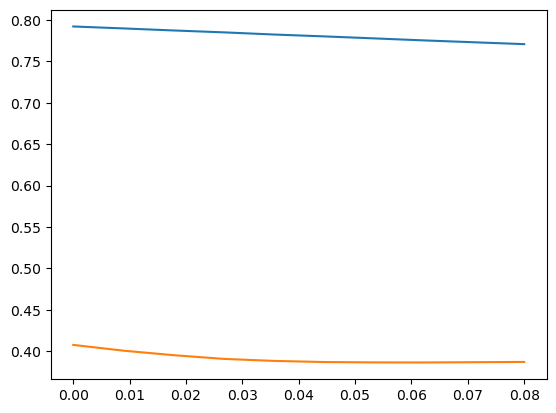

In [13]:
gammas = np.linspace(0,0.08,10)
nb_steps = 15

gammas, f1_tr, f1_te = choose_best_gamma(balanced_x_train, balanced_y_train, x_te, y_te, gammas, nb_steps)


In [ ]:
weights = []
losses = []
gamma = 0.05555555555555556
nb_steps = 100

f1_score = []

for i in range(len(balanced_x_train)):
    w = w_LS
    
    for j in range(nb_steps):
        w,_ = logistic_regression(balanced_y_train[i], balanced_x_train[i], w, gamma)
    weights.append(w)
    f1_score.append( compute_f1(y_te, sigmoid_prediction(y_te, x_te, w, threshold = 0.55)[0]))

    
w_LOG = np.mean(weights, axis = 0)
f1_ = np.mean(f1_score)
print('f1 : ', f1_)

## 6) Regularized Logistic Regression

In [20]:
weights = []
losses = []
gamma = 0.02
nb_steps = 20
lambda_ = 0.04


for i in range(len(balanced_x_train)):
    w = w_LS
    for j in range(nb_steps):
        w,_ = reg_logistic_regression(balanced_y_train[i], balanced_x_train[i], w, gamma, lambda_)
    weights.append(w)
    
w_RLOG = np.mean(weights, axis = 0)
f1 = compute_f1(y_te, sigmoid_prediction(y_te, x_te, w_RLOG)[0])
loss = sigmoid_prediction(y_te, x_te, w_RLOG)[1]
loss = compute_loss(y_te, x_te, w_RLOG)
print('Loss with test set : ',loss, 'f1 : ', f1)

Loss with test set :  0.3509700747180164 f1 :  0.3491912115321131
